# <font color='blue' size=20>SPS Jupyter Notebook v1.0</font>

#  <font color='red'>GENERAL SETUP</font>

#### Loading Libraries

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random
from numpy.polynomial import Polynomial
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from IPython.display import clear_output, display

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### Functions

In [2]:
# Function of Serge
# Transforms a dictionary to two X, Y list
# Useful for dictionaries with kids as key and tuple of values needed
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

# Function of Serge
# Useful for neural network, transforms 5 to [0,0,0,0,0,1,0,0],
# Not perfect yet
# input i = 5, maxi = 7.
def mabc_to_arr(i, maxi):
    lb = preprocessing.LabelBinarizer()
    lb.fit(list(range(0, maxi)))
    return (lb.transform([i])[0])

# Function of Serge
# Useful to spot difference between well-developed and lower-developed kids
# inpit: feature u want to check, snelheid=on which speed, time= 0 or 1 (depending on if u want to check first or last round they played)
def poly_difference(feature, snelheid=0.6, time=0):
    X, Y, problematic_x, problematic_y, developed_x, developed_y, developed_weight, problematic_weight = [], [], [], [], [], [], [], []

    plt.title("Individual {} polynomials of each child on speed {}".format(feature, snelheid))

    for child_id in children_ids:
        child_frame = rr_221100.loc[(rr_221100['ID'] == child_id) & (rr_221100['snelheid'] == snelheid)]

        child_frame_1 = child_frame.loc[(child_frame['times_level_played_before'] == 1)]
        times_1 = list(child_frame_1['time_resetted_each_round'])
        feature_1 = list(child_frame_1[feature])

        child_frame_2 = child_frame.loc[(child_frame['times_level_played_before'] == 2)]
        times_2 = list(child_frame_2['time_resetted_each_round'])
        feature_2 = list(child_frame_2[feature])
        
        times_list = [times_1, times_2]
        feature_list = [feature_1, feature_2]
        
        mabc_percentile = list(child_frame['mabc_percentile_score'].head(1))[0]
        mabc_binary = list(child_frame['mabc_binary_score'].head(1))[0]

        p = Polynomial.fit(times_list[time], feature_list[time], 7)
        y_polynomial = np.array(p.linspace()[1])
        x_polynomial = np.array(p.linspace()[0])

        X.append(y_polynomial)
        Y.append(mabc_to_arr(int(mabc_binary), 2))

        if list(child_frame['mabc_binary_score'].head(1))[0]:
            problematic_y.append(y_polynomial)
            problematic_x.append(x_polynomial)
            color = 'red'
            label = 'low'
            weight = (100 - mabc_percentile)/100
            problematic_weight.append(weight)
        else:
            developed_y.append(y_polynomial)
            developed_x.append(x_polynomial)
            color = 'green'
            label = 'well'
            weight = mabc_percentile/100
            developed_weight.append(weight)


        plt.plot(x_polynomial, y_polynomial, linewidth=0.5, color=color, label="polyfit")

    plt.show()
    X = np.array(X)
    Y = np.array(Y)
    
    problematic_sum_y = [((1/len(problematic_y))*sum(x)) for x in zip(*problematic_y)]
    problematic_sum_x = [((1/len(problematic_x))*sum(x)) for x in zip(*problematic_x)]

    developed_sum_y = [((1/len(developed_y))*sum(x)) for x in zip(*developed_y)]
    developed_sum_x = [((1/len(developed_x))*sum(x)) for x in zip(*developed_x)]
    
    plt.plot(problematic_sum_x, problematic_sum_y, label="average {}-score of all problematic kids".format(feature))
    plt.plot(developed_sum_x, developed_sum_y, label="average {}-score of all developed kids".format(feature))
    plt.title("Problematic and well-developed children average {}-score on speed {}".format(feature, snelheid))
    plt.legend()
    plt.show()
    
    # returns the two averaged polynomials so it could be used for mean squared or anthing
    return (problematic_sum_x, problematic_sum_y), (developed_sum_x, developed_sum_y)




#### Importing Data

In [3]:
rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

#### Deleting warmup from rr and m

In [4]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

#### Previewing data

In [5]:
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


In [6]:
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


#  <font color='red'>CRAFTED DATAFRAMES</font>

#### rr_data_time contains 'real_time' which resets per child and runs from 0 to 240.
#### python_tijd was dropped too.

In [7]:
rr_data_time = rr_data

subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]
children_ids = set(subdata['ID'])

times = []

for percent, child_id in enumerate(children_ids):
    child_frame = rr_data.loc[subdata['ID'] == child_id]
    mintime = child_frame['python_tijd'].min()
    fixedtime = child_frame['python_tijd'] - mintime
    times.append(fixedtime.values)
    
    # so you know how long it takes
    clear_output(wait=True)
    print(round(percent*1.053), " percent loading")
    
realtimes = [item for sublist in times for item in sublist]
rr_data_time.insert(4, 'real_time', realtimes)
rr_data_time.drop(columns=['python_tijd'])
clear_output(wait=True)

100  percent loading


#### rr_221100 contains 'time_resetted_per_round' which resets per child  per round.  <br> It also makes sure that the rows are ordered by level as follows (221100)

In [8]:
rr_221100 = pd.DataFrame()

newtimelist = []
newlevellist = []

for percent, child_id in enumerate(children_ids):
    child_frame = rr_data_time.loc[rr_data_time['ID'] == child_id]

    level_00_1 = child_frame.loc[(child_frame['snelheid'] == 0.4) & (child_frame['times_level_played_before'] == 1)]
    level_00_2 = child_frame.loc[(child_frame['snelheid'] == 0.4) & (child_frame['times_level_played_before'] == 2)]
    level_11_1 = child_frame.loc[(child_frame['snelheid'] == 0.6) & (child_frame['times_level_played_before'] == 1)]
    level_11_2 = child_frame.loc[(child_frame['snelheid'] == 0.6) & (child_frame['times_level_played_before'] == 2)]
    level_22_1 = child_frame.loc[(child_frame['snelheid'] == 0.8) & (child_frame['times_level_played_before'] == 1)]
    level_22_2 = child_frame.loc[(child_frame['snelheid'] == 0.8) & (child_frame['times_level_played_before'] == 2)]

    level_00 = list(level_00_1['real_time'] - level_00_1['real_time'].min()) + (list(level_00_2['real_time'] - level_00_2['real_time'].min()))
    level_11 = list(level_11_1['real_time'] - level_11_1['real_time'].min()) + (list(level_11_2['real_time'] - level_11_2['real_time'].min()))
    level_22 = list(level_22_1['real_time'] - level_22_1['real_time'].min()) + (list(level_22_2['real_time'] - level_22_2['real_time'].min()))

    newtimelist += level_00 + level_11 + level_22
    
    rr_221100 = rr_221100.append(level_00_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_00_2, ignore_index = True)
    rr_221100 = rr_221100.append(level_11_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_11_2, ignore_index = True)
    rr_221100 = rr_221100.append(level_22_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_22_2, ignore_index = True)
    
    # so you know how long it takes
    clear_output(wait=True)
    print(round(percent*1.053), " percent loading")
    
rr_221100.insert(4, 'time_resetted_each_round', newtimelist) 


100  percent loading


#  <font color='red'>PLOTS</font>

#### PLOT 1: Correlation between MABC and average costheta

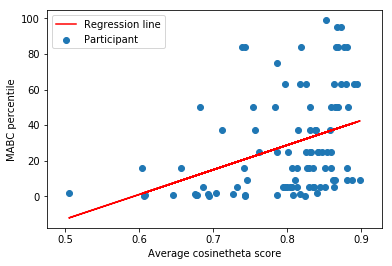

In [9]:
# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)

avg_ct, mabc = dict_to_x_y(subdata_dictionary)

# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


#### PLOT 2: Correlation between MABC and average jerk

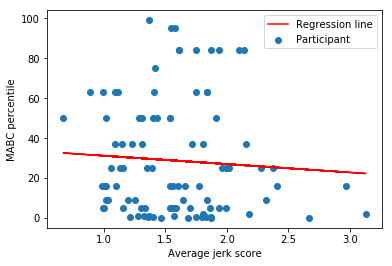

In [10]:

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
    
avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


#### PLOT 3: Correlation between average costheta and rounds

Average costheta per round for all kids:
   level  costheta
0      0  0.814482
1      1  0.800522
2      2  0.781877
[0.814481824505863, 0.8005219329437955, 0.7818773117634136]


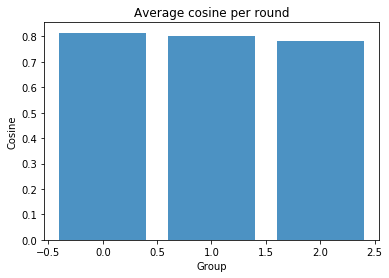

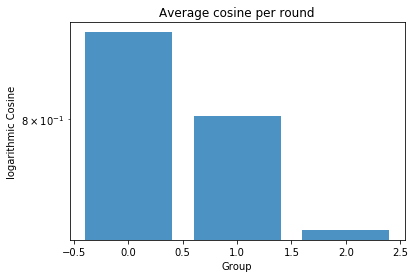

In [11]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print("Average costheta per round for all kids:")
print(rr_221100.groupby('level', as_index=False)['costheta'].mean())
print(list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['level'])
cos_rounds = list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

In [12]:
#### PLOT 4: ... 

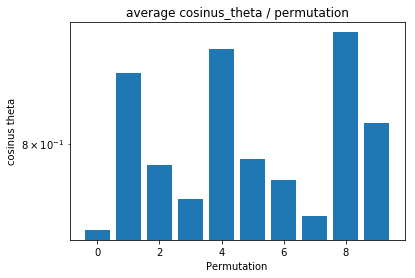

In [13]:
# BAR CHART average cosinus_theta / permutation
permutations = sorted(rr_data['permutation'].unique())

means = []
for p in permutations:
    thispermutation = rr_data.loc[rr_data['permutation'] == p]
    means.append(thispermutation['costheta'].mean())
    
    
plt.bar(permutations, means, log=True)
plt.xlabel('Permutation')
plt.ylabel('cosinus theta')
plt.title('average cosinus_theta / permutation')
plt.savefig('plots/cosine_permutation.png', dpi=100)
plt.show()

#### INFO 5: Avarage age of participants

In [14]:
## get dataframe with only IDs for Average age
ids = rr_data['ID'].unique()
rr_data_id = rr_data.groupby('ID').first()
ages = list(rr_data_id['age_precise'])
print('The average age of all participants is {}'.format(np.mean(ages)))

percs = list(rr_data_id['mabc_percentile_score'])

The average age of all participants is 7.829102126212949


#### PLOT 6: Pie charts of the genders

Text(0.5,1,'Gender distribution')

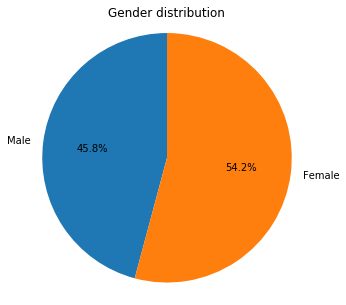

In [15]:
# pie chart of genders
genderlist = list(rr_data_id.groupby('gender').size())
labels = 'Male', 'Female'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(genderlist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Gender distribution')
# uncomment for save:
# fig1.savefig('plots/gender_pie.png', dpi=100)



#### PLOT 6: Pie charts of the MABC

Text(0.5,1,'mABC test result')

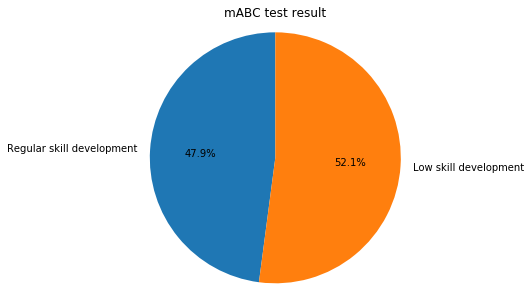

In [16]:
# pie chart of MABC score
abclist = list(rr_data_id.groupby('mabc_binary_score').size())
labels = 'Regular skill development', 'Low skill development'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(abclist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('mABC test result')
# uncomment for save:
# fig1.savefig('plots/mABC_pie.png', dpi=100)

#### PLOT 7: Pie charts of the MABC

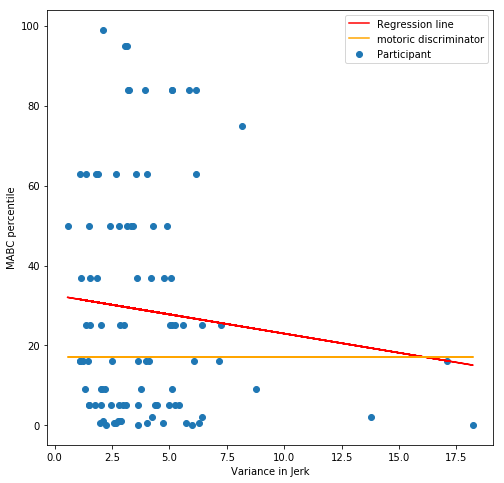

In [17]:
# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    var_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].var()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (var_jerk, mabc_perc)

var_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(var_jerk, mabc)
var_jerk_slope = [i * slope for i in var_jerk]

# scatter plot with mabc
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(var_jerk, mabc, label='Participant')
plt.plot(var_jerk, intercept + var_jerk_slope, 'r', label='Regression line')
plt.plot(var_jerk, [17 for i in range(len(var_jerk))], 'orange', label='motoric discriminator')
plt.xlabel("Variance in Jerk")
plt.ylabel("MABC percentile")
plt.legend()

#### Plot 8: Variance in Jerk in relation to speed

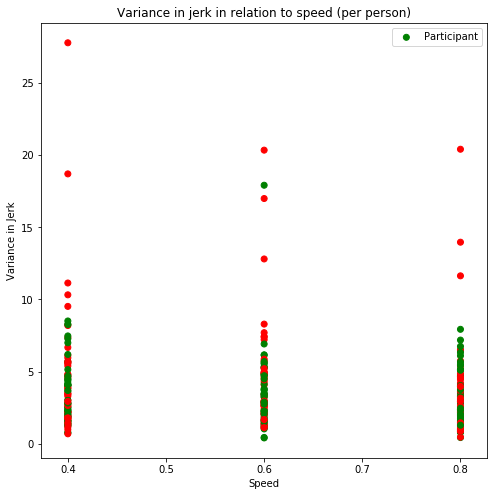

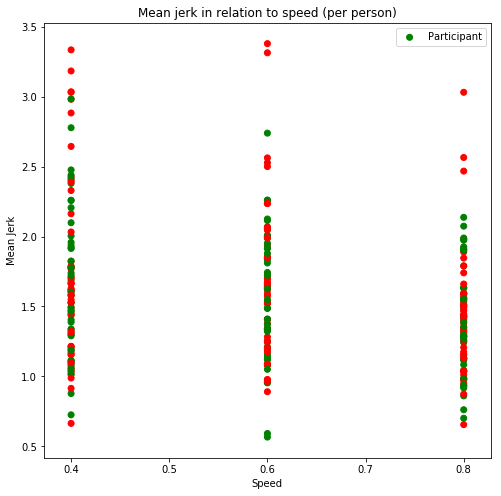

In [18]:
# create a dataframe containing this data
subdata_jerk_speed = rr_data[['ID', 'jerk', 'mabc_binary_score', 'snelheid', 'round']]

speedset = set(subdata_jerk_speed['snelheid'])


subdata_jerk_speed.head(10)


var_jerk_list = []
mean_jerk_list = []
speed_list = []
mabc_list = []

# onderpresterende kinderen reacting to snelheid en jerk
for child_id in children_ids:
    mabc = subdata_jerk_speed.loc[subdata_jerk_speed['ID'] == child_id]['mabc_binary_score'].mean()
    for speed in speedset:
        var_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].var()
        mean_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].mean()
#         print(child_id, "has", mean_jerk, var_jerk, " on speed", speed, ". His MABS is:", mabc)
        speed_list.append(speed)
        var_jerk_list.append(var_jerk)
        mean_jerk_list.append(mean_jerk)
        mabc_list.append(mabc)
#     print()

color_list = ['green' if int(i) is 0 else 'red' for i in mabc_list]

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(speed_list, var_jerk_list, color=color_list, label='Participant')
plt.title("Variance in jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Variance in Jerk")
plt.show()

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(speed_list, mean_jerk_list, color=color_list, label='Participant')
plt.title("Mean jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Mean Jerk")
plt.show()


#### Plot 9: ....

     round  costheta
0  level_A  0.840348
1  level_B  0.812286
2  level_C  0.782614
3  level_D  0.783407
4  level_E  0.789382
5  level_F  0.785403
[0.8403480702396885, 0.8122860235096364, 0.7826141749435335, 0.7834074690478088, 0.7893822278971558, 0.7854031804682886]


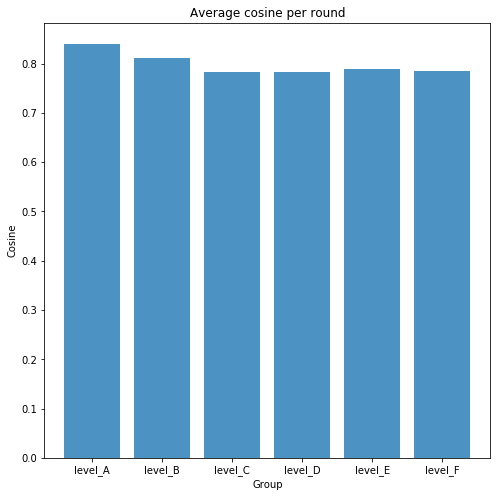

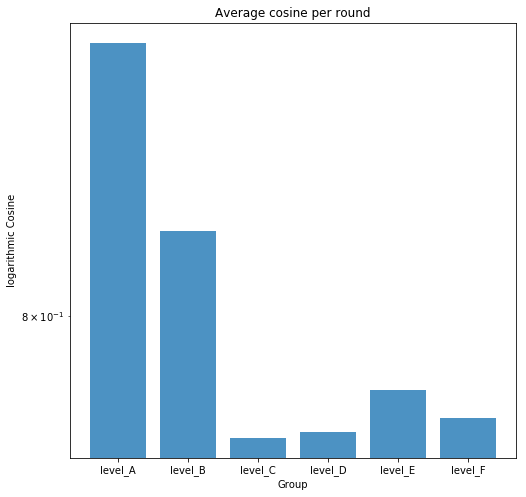

In [19]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print(rr_data.groupby('round', as_index=False)['costheta'].mean())
print(list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['round'])
cos_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

#### Plot 10: Mean and var of cosine per level

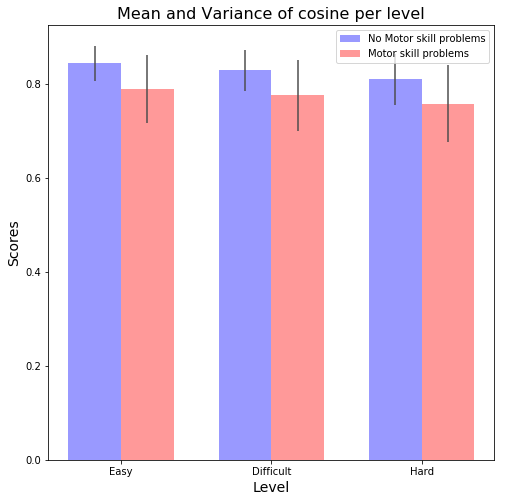

In [20]:
# drop ID 255
rr_data_dropped = rr_data
rr_data_dropped = rr_data_dropped.drop(rr_data[rr_data.ID == 255].index)

# divide dataset based on mABC score
normaal = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 0]
gestoord = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 1]

# get average cosines of normal kids
normaal_avgcos = list(normaal.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get average cosines of gestoorde kids
gestoord_avgcos = list(gestoord.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get variance of cosines of normal en gestoorde kids
normaal_var = list(normaal.groupby('level', as_index=False)['costheta'].var()['costheta'])
gestoord_var = list(gestoord.groupby('level', as_index=False)['costheta'].var()['costheta'])

# plot beautiful barchart
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = 3
fig, ax = plt.subplots()
plt.figure(figsize=(8,6))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, normaal_avgcos, bar_width,
                alpha=opacity, color='b',
                yerr=normaal_var, error_kw=error_config,
                label='No Motor skill problems')

rects2 = ax.bar(index + bar_width, gestoord_avgcos, bar_width,
                alpha=opacity, color='r',
                yerr=gestoord_var, error_kw=error_config,
                label='Motor skill problems')

ax.set_xlabel('Level', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mean and Variance of cosine per level', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Easy', 'Difficult', 'Hard'))
ax.legend()
# uncomment for save
# fig.savefig('plots/mean_var_cos_per_level.png', dpi=100)

plt.show()

#### Plot 11: Correlation between rr & m game

The average of children without motor skill problems : 0.2940828632338094
The average of children with motor skill problems : 0.3221141618978073


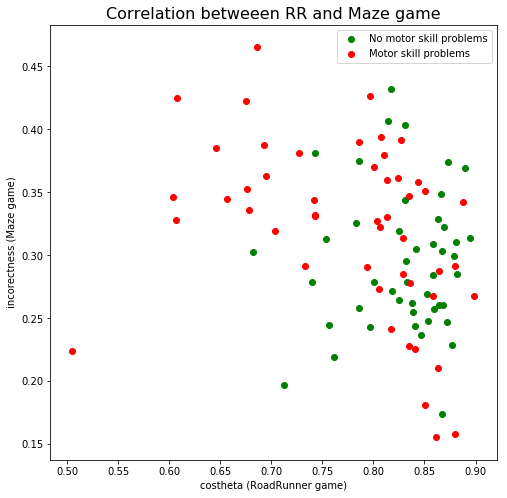

In [21]:
# difference Roadrunner en maze lilcasp
# avg costheta roadrunner participants
rr_costheta_normaal = list((normaal.groupby('ID', as_index=False)['costheta'].mean()['costheta']))
rr_costheta_gestoord = list((gestoord.groupby('ID', as_index=False)['costheta'].mean()['costheta']))

# split data of maze 
normaal_m = m_data[m_data['mabc_binary_score'] == 0]
gestoord_m = m_data[m_data['mabc_binary_score'] == 1]

m_incorrect_normaal = list((normaal_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))
m_incorrect_gestoord = list((gestoord_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))

print('The average of children without motor skill problems : {}'.format(np.mean(m_incorrect_normaal)))
print('The average of children with motor skill problems : {}'.format(np.mean(m_incorrect_gestoord)))

# plot this babe
plt.scatter(rr_costheta_normaal, m_incorrect_normaal, color='green', label='No motor skill problems')
plt.scatter(rr_costheta_gestoord, m_incorrect_gestoord, color='red', label='Motor skill problems')
plt.title('Correlation betweeen RR and Maze game', fontsize=16)
plt.xlabel('costheta (RoadRunner game)')
plt.ylabel('incorectness (Maze game)')
plt.legend()
# plt.savefig('plots/correlation_RR_M.png', dpi=100)
plt.show()

# Some 3d plots

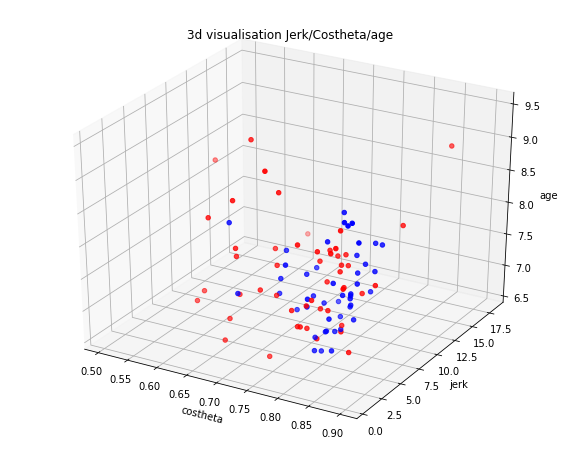

In [38]:
# get list of ids
ids = rr_data['ID'].unique()

# get df with 1 row per child
rr_data_id_means = rr_data.groupby('ID', as_index=False).first()

# iterate over children and get mean of child
meancols = ['costheta']
for curid in ids:
    for idx, meancol in enumerate(meancols):
        # get mean of original rr_data of this child
        currentmean = rr_data.loc[rr_data['ID'] == curid][meancol].mean()
        
        # change current value in df with 1 row per child
        rr_data_id_means.loc[rr_data_id_means.ID == curid, meancol] = currentmean
        
# iterate over children and get mean of child
varcols = ['jerk']
for curid in ids:
    for idx, varcol in enumerate(varcols):
        # get mean of original rr_data of this child
        currentvar = rr_data.loc[rr_data['ID'] == curid][varcol].var()
        
        # change current value in df with 1 row per child
        rr_data_id_means.loc[rr_data_id_means.ID == curid, varcol] = currentvar

# select wich columns you want
rr_data_id_means = rr_data_id_means[['costheta', 'age_precise', 'mabc_binary_score', 'jerk']]

plotlist = np.array(rr_data_id_means[['costheta', 'jerk', 'age_precise']].values.tolist())

colorlist = list(rr_data_id_means['mabc_binary_score'])
colorlist = ['red' if x==1 else 'blue' for x in colorlist]

# print(cos_snel[:,1])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plotlist[:,0], plotlist[:,1], plotlist[:,2], color=colorlist)
ax.set_xlabel('costheta')
ax.set_ylabel('jerk')
ax.set_zlabel('age')
ax.set_title('3d visualisation Jerk/Costheta/age')
plt.show()

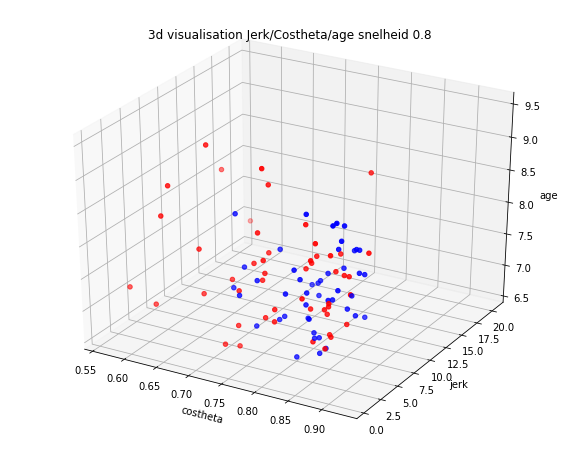

In [41]:
# 3d plot met alleen datapunten met snelheid 0.8/0.6/0.4 (verander zelf)
speed = 0.8
rr_data_fast = rr_data.loc[rr_data['snelheid'] == speed]

# get list of ids
ids = rr_data['ID'].unique()

# get df with 1 row per child
rr_data_id_means = rr_data.groupby('ID', as_index=False).first()

# iterate over children and get mean of child
meancols = ['costheta']
for curid in ids:
    for idx, meancol in enumerate(meancols):
        # get mean of original rr_data of this child
        currentmean = rr_data_fast.loc[rr_data_fast['ID'] == curid][meancol].mean()
        
        # change current value in df with 1 row per child
        rr_data_id_means.loc[rr_data_id_means.ID == curid, meancol] = currentmean
        
# iterate over children and get mean of child
varcols = ['jerk']
for curid in ids:
    for idx, varcol in enumerate(varcols):
        # get mean of original rr_data of this child
        currentvar = rr_data_fast.loc[rr_data_fast['ID'] == curid][varcol].var()
        
        # change current value in df with 1 row per child
        rr_data_id_means.loc[rr_data_id_means.ID == curid, varcol] = currentvar

# select wich columns you want
rr_data_id_means = rr_data_id_means[['costheta', 'age_precise', 'mabc_binary_score', 'jerk']]
rr_data_id_means.head()


# plot distribution jerk
from mpl_toolkits.mplot3d import Axes3D
jerktest = np.array(rr_data_id_means[['costheta', 'jerk', 'age_precise']].values.tolist())

colorlist = list(rr_data_id_means['mabc_binary_score'])
colorlist = ['red' if x==1 else 'blue' for x in colorlist]

# print(cos_snel[:,1])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(jerktest[:,0], jerktest[:,1], jerktest[:,2], color=colorlist)
ax.set_xlabel('costheta')
ax.set_ylabel('jerk')
ax.set_zlabel('age')
ax.set_title('3d visualisation Jerk/Costheta/age snelheid {}'.format(speed))
plt.show()

#  <font color='red'>Machine Learning</font>

#### Splits all rows in training data, validation data and testing data. 

In [22]:
# shuffle this list
shuffled_kids = random.sample(list(children_ids), len(list(children_ids)))

# 56 kinderen training
# 20 kinderen
# 20 kinderen
training_kids = shuffled_kids[:56]
val_kids = shuffled_kids[56:76]
testing_kids = shuffled_kids[76:96]

rr_training_data = rr_data.loc[rr_data['ID'].isin(training_kids)]
rr_val_data = rr_data.loc[rr_data['ID'].isin(val_kids)]
rr_testing_data = rr_data.loc[rr_data['ID'].isin(testing_kids)]

#### Applies polynomial regression on each kid on the round with the 0.4 speed (level_2). <br> Possible to plot. <br> Creates array with X as training data (polynomial regression coordinates) and Y is just the label (problem or not)

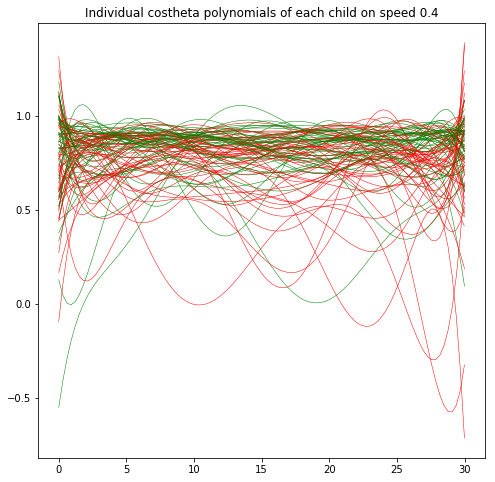

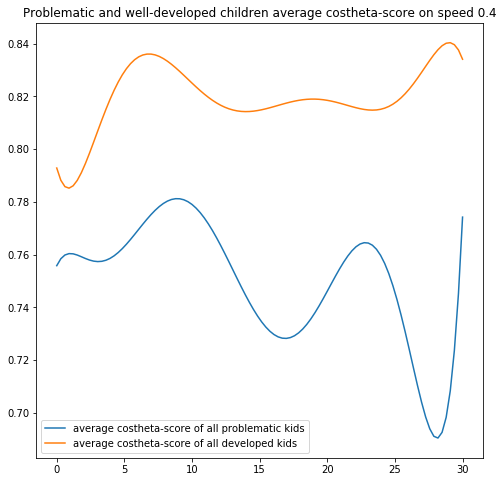

(([0.0,
   0.3029616161789556,
   0.6059232323579112,
   0.9088848485368667,
   1.2118464647158225,
   1.5148080808947781,
   1.8177696970737334,
   2.12073131325269,
   2.423692929431645,
   2.7266545456106037,
   3.0296161617895563,
   3.332577777968512,
   3.6355393941474667,
   3.9385010103264233,
   4.24146262650538,
   4.544424242684331,
   4.84738585886329,
   5.150347475042247,
   5.453309091221207,
   5.756270707400157,
   6.059232323579113,
   6.3621939397580745,
   6.665155555937024,
   6.968117172115983,
   7.2710787882949335,
   7.574040404473892,
   7.877002020652847,
   8.179963636831808,
   8.48292525301076,
   8.785886869189719,
   9.088848485368661,
   9.391810101547627,
   9.69477171772658,
   9.997733333905538,
   10.300694950084495,
   10.603656566263451,
   10.906618182442415,
   11.209579798621357,
   11.512541414800314,
   11.815503030979276,
   12.118464647158225,
   12.42142626333718,
   12.724387879516149,
   13.027349495695093,
   13.330311111874048,
   13.6

In [23]:
poly_difference('costheta', 0.4, 1)

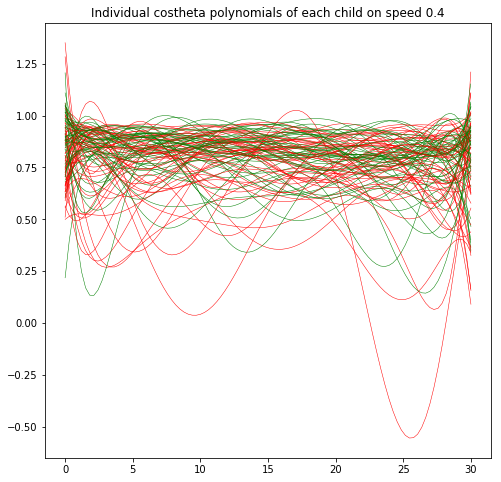

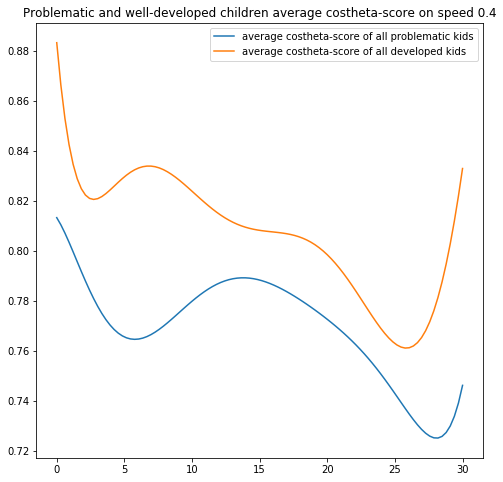

(([0.0,
   0.3029696970274954,
   0.6059393940549908,
   0.9089090910824859,
   1.2118787881099815,
   1.514848485137477,
   1.8178181821649717,
   2.1207878791924686,
   2.423757576219963,
   2.7267272732474614,
   3.029696970274954,
   3.3326666673024508,
   3.6356363643299434,
   3.93860606135744,
   4.241575758384937,
   4.544545455412426,
   4.847515152439926,
   5.150484849467424,
   5.453454546494923,
   5.756424243522412,
   6.059393940549908,
   6.362363637577409,
   6.6653333346049015,
   6.968303031632399,
   7.271272728659887,
   7.574242425687384,
   7.87721212271488,
   8.18018181974238,
   8.483151516769874,
   8.786121213797372,
   9.089090910824853,
   9.392060607852356,
   9.695030304879852,
   9.998000001907348,
   10.300969698934848,
   10.60393939596234,
   10.906909092989846,
   11.209878790017328,
   11.512848487044824,
   11.815818184072326,
   12.118787881099816,
   12.421757578127306,
   12.724727275154818,
   13.0276969721823,
   13.330666669209803,
   13.633

In [24]:
poly_difference('costheta', 0.4, 0)

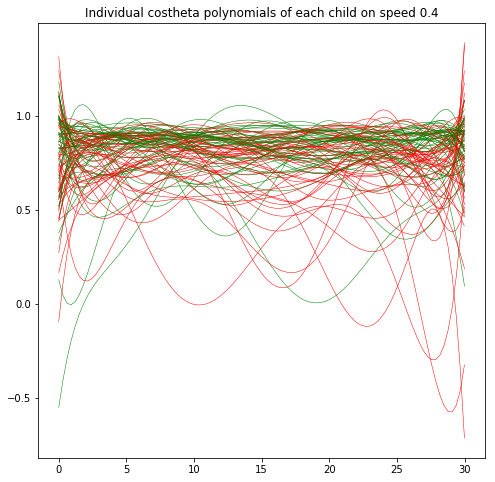

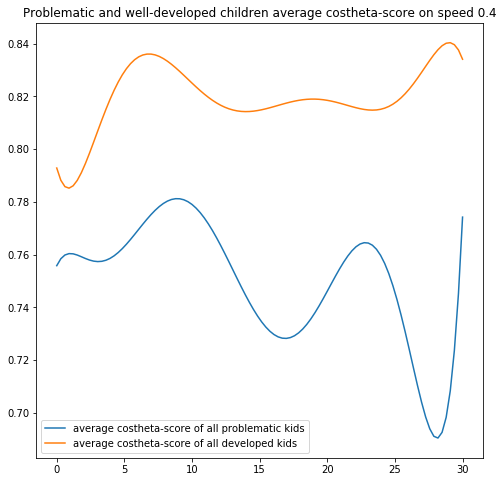

([0.0, 0.3029616161789556, 0.6059232323579112, 0.9088848485368667, 1.2118464647158225, 1.5148080808947781, 1.8177696970737334, 2.12073131325269, 2.423692929431645, 2.7266545456106037, 3.0296161617895563, 3.332577777968512, 3.6355393941474667, 3.9385010103264233, 4.24146262650538, 4.544424242684331, 4.84738585886329, 5.150347475042247, 5.453309091221207, 5.756270707400157, 6.059232323579113, 6.3621939397580745, 6.665155555937024, 6.968117172115983, 7.2710787882949335, 7.574040404473892, 7.877002020652847, 8.179963636831808, 8.48292525301076, 8.785886869189719, 9.088848485368661, 9.391810101547627, 9.69477171772658, 9.997733333905538, 10.300694950084495, 10.603656566263451, 10.906618182442415, 11.209579798621357, 11.512541414800314, 11.815503030979276, 12.118464647158225, 12.42142626333718, 12.724387879516149, 13.027349495695093, 13.330311111874048, 13.633272728052999, 13.936234344231966, 14.239195960410921, 14.542157576589867, 14.845119192768832, 15.148080808947784, 15.451042425126747, 

In [36]:
# get mse of current child bij snelheid
x, y = poly_difference('costheta', 0.4, 1)

print(x)


# NN poging 1

In [45]:
# get list all ids
ids = rr_data['ID'].unique()
tempids = [101, 102]

# get df with 1 row per child 
# only use certain features
rr_data_id_means = rr_data_time.groupby('ID', as_index=False).first()[["ID", 'mabc_binary_score']]

# add empty columns to df
pd.concat([rr_data_id_means, pd.DataFrame(columns=['goodcos', 'jerkmse', 'cosmean', 'cosvar', 'jerkmean', 'jerkvar', 'cosmean0', 'cosmean1', 'cosmean2', 'cosvar0', 'cosvar1', 'cosvar2', 
                                                   'jerkmean0','jerkmean1', 'jerkmean2', 'jerkvar0', 'jerkvar1', 'jerkvar2' ])])

# add mean column for each feature
for idx, child in enumerate(ids):
    rr_data_child = rr_data_time[rr_data_time['ID'] == child]
    #########
    # HIER WORDEN NIEUWE FEATURES VOOR IN DE DF BEREKEND
    #########
    # easy features
    cosmean = rr_data_child['costheta'].mean()
    cosvar = rr_data_child['costheta'].var()
    jerkmean = rr_data_child['costheta'].mean()
    jerkvar  = rr_data_child['costheta'].var()
    
    # jerk mse
    y_true = list(rr_data_child['jerk'])
    y_pred = [rr_data_child['jerk'].mean()] * len(y_true)
    jerkmse = mean_squared_error(y_true, y_pred)   
    
    # cosine features
    cosmean0 = rr_data_child[rr_data_child['level'] == 0].mean()['costheta']
    cosmean1 = rr_data_child[rr_data_child['level'] == 1].mean()['costheta']
    cosmean2 = rr_data_child[rr_data_child['level'] == 2].mean()['costheta']
    
    cosvar0 = rr_data_child[rr_data_child['level'] == 0].var()['costheta']
    cosvar1 = rr_data_child[rr_data_child['level'] == 1].var()['costheta']
    cosvar2 = rr_data_child[rr_data_child['level'] == 2].var()['costheta']
    
    # jerk features
    jerkmean0 = rr_data_child[rr_data_child['level'] == 0].mean()['jerk']
    jerkmean1 = rr_data_child[rr_data_child['level'] == 1].mean()['jerk']
    jerkmean2 = rr_data_child[rr_data_child['level'] == 2].mean()['jerk']
    
    jerkvar0 = rr_data_child[rr_data_child['level'] == 0].var()['jerk']
    jerkvar1 = rr_data_child[rr_data_child['level'] == 1].var()['jerk']
    jerkvar2 = rr_data_child[rr_data_child['level'] == 2].var()['jerk']
    
    goodcos = rr_data_child[rr_data_child['costheta'] > 0.99].sum()['costheta']
    
    #########
    # HIER WORDEN DIE FEATURES TOEGEVOEGD AAN DF
    #########
    # add everything to df
    rr_data_id_means.loc[idx,'cosmean'] = cosmean
    rr_data_id_means.loc[idx,'cosvar'] = cosvar
    rr_data_id_means.loc[idx,'jerkmean'] = jerkmean
    rr_data_id_means.loc[idx,'jerkvar'] = jerkvar
    rr_data_id_means.loc[idx,'jerkmse'] = jerkmse
    
    rr_data_id_means.loc[idx,'cosmean0'] = cosmean0
    rr_data_id_means.loc[idx,'cosmean1'] = cosmean1
    rr_data_id_means.loc[idx,'cosmean2'] = cosmean2
    rr_data_id_means.loc[idx,'cosvar0'] = cosvar0
    rr_data_id_means.loc[idx,'cosvar1'] = cosvar1
    rr_data_id_means.loc[idx,'cosvar2'] = cosvar2
    rr_data_id_means.loc[idx,'jerkmean0'] = jerkmean0
    rr_data_id_means.loc[idx,'jerkmean1'] = jerkmean1
    rr_data_id_means.loc[idx,'jerkmean2'] = jerkmean2
    rr_data_id_means.loc[idx,'jerkvar0'] = jerkvar0
    rr_data_id_means.loc[idx,'jerkvar1'] = jerkvar1
    rr_data_id_means.loc[idx,'jerkvar2'] = jerkvar2
    
    rr_data_id_means.loc[idx,'goodcos'] = goodcos
    rr_data_id_means.loc[idx,'jerkmse'] = jerkmse
    
    # loading time (dit was slim serge)
    clear_output(wait=True)
    print(round(idx*1.053), " percent loading")
    
print('done! this is your df now:')
print(rr_data_id_means.head(3))

100  percent loading
done! this is your df now:
    ID  mabc_binary_score   cosmean    cosvar  jerkmean   jerkvar    jerkmse  \
0  101                  0  0.830528  0.042719  0.830528  0.042719   1.524379   
1  102                  1  0.694703  0.126739  0.694703  0.126739   2.217343   
2  103                  1  0.505019  0.233741  0.505019  0.233741  13.773121   

   cosmean0  cosmean1  cosmean2   cosvar0   cosvar1   cosvar2  jerkmean0  \
0  0.872454  0.770831  0.848985  0.016205  0.062980  0.042997   1.042448   
1  0.788203  0.779871  0.516048  0.084935  0.074449  0.172944   1.155672   
2  0.589149  0.442366  0.483534  0.232035  0.239133  0.218656   3.031132   

   jerkmean1  jerkmean2   jerkvar0   jerkvar1   jerkvar2      goodcos  
0   1.156437   1.078103   1.331767   1.648555   1.584652  1175.950980  
1   1.615332   1.617792   1.452692   2.843571   2.214981  1322.804384  
2   3.313461   3.034559  13.964242  16.985817  10.323133   796.705523  


In [26]:
# split into training and validation set
def validation_split(data, ratio):
    # do not shuffle data --> nog veranderen in dat het wel shuffled
    shuffled = data.sample(frac=1).reset_index(drop=True)

    # calculate number of rows for training
    trainrows = int(ratio * len(shuffled))
    train = shuffled[:trainrows]
    val = shuffled[trainrows:]
    
    return train, val

def x_y_split(df):
    # x is data without mabc
    x = df.loc[:, df.columns != 'mabc_binary_score']
    x = x.values

    # y is mabc
    y = df.loc[:, df.columns == 'mabc_binary_score']
    
    # flatten y forright dimensions
    y = [item for sublist in y.values for item in sublist]
    
    return x, y

# split function that excepts which labels to keep after split
def x_y_split_labels(df, labels):
    x = df[labels]
    x = x.values

    # y is mabc column
    y = df.loc[:, df.columns == 'mabc_binary_score']
    
    # flatten y forright dimensions
    y = [item for sublist in y.values for item in sublist]
    
    return x, y

# drop ID numbers
rr_data_id_means = rr_data_id_means.loc[:, rr_data_id_means.columns != 'ID']

# split in training and validation set
train, val = validation_split(rr_data_id_means, 0.7)

# x is data, y are the labels
xtrain, ytrain = x_y_split(train)
xval, yval = x_y_split(val)

In [34]:
correctness_list = []

for i in range(20):        
    # split in training and validation set
    train, val = validation_split(rr_data_id_means, 0.6)

    # GEEF HIER AAN WELKE COLUMNS JE WILT TESTEN!
    xtrain, ytrain = x_y_split_labels(train, [ 'cosmean', 'goodcos'])
    xval, yval = x_y_split_labels(val, [ 'cosmean', 'goodcos'])

    # classify
    clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(100,), random_state=1)
    clf.fit(xtrain, ytrain)     

    MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
                  beta_1=0.9, beta_2=0.999, early_stopping=False,
                  epsilon=1e-08, hidden_layer_sizes=(100,),
                  learning_rate='constant', learning_rate_init=0.001,
                  max_iter=200, momentum=0.9, n_iter_no_change=1000,
                  nesterovs_momentum=True, power_t=0.5, random_state=1,
                  shuffle=True, solver='sgd', tol=0.0001,
                  validation_fraction=0.1, verbose=False, warm_start=False)

    correct = 0

    for x, y in zip(xval, yval):
        pred = clf.predict([x])
        if pred == y:
            correct += 1

    perc = correct/len(yval) * 100

    correctness_list.append(perc)
    
avg = np.mean(correctness_list)
print('Correctly classified: {}%'.format(avg))

Correctly classified: 52.30769230769231%
